In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
from astropy.table import Table 
from astropy.nddata import CCDData
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.time import Time, TimeDeltaSec

from tqdm import tqdm_notebook

import glowing_waffles.differential_photometry as gwdf

## This should be any one of the images in your table

In [2]:
ccd = CCDData.read('tres-3-010R.fit')

In [3]:
apass, apass_x, apass_y, apass_for_transform, in_apass_x, in_apass_y = gwdf.find_apass_stars(ccd)
vsx, vsx_x, vsx_y, vsx_names = gwdf.find_known_variables(ccd)

apass_all_coords = SkyCoord(apass['RAJ2000'], apass['DEJ2000'], unit='deg')
apass_for_transform_coords = SkyCoord(apass_for_transform['RAJ2000'], apass_for_transform['DEJ2000'], unit='deg')

/Users/mcraig/conda-main/envs/ipyfits/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [4]:
apass.colnames

['_q',
 'recno',
 'RAJ2000',
 'DEJ2000',
 'e_RAJ2000',
 'e_DEJ2000',
 'Field',
 'nobs',
 'mobs',
 'B-V',
 'e_B-V',
 'Vmag',
 'e_Vmag',
 'Bmag',
 'e_Bmag',
 'g_mag',
 'e_g_mag',
 'r_mag',
 'e_r_mag',
 'i_mag',
 'e_i_mag']

In [5]:
apass['R_mag'] = gwdf.filter_transform(apass, 'R', g='g_mag', r='r_mag', i='i_mag', transform='ivezic')

In [6]:
apass_for_transform['R_mag'] = gwdf.filter_transform(apass_for_transform, 'R', g='g_mag', r='r_mag', i='i_mag', transform='ivezic')

## Change the file name below to match the one your magnitudes are in

In [7]:
input_mags = Table.read('tres-3-rearranged.fits')

input_mags['mag_inst_R'][np.isinf(input_mags['mag_inst_R'])] = np.nan

### Get our "star_id" for Kelt-16

In [8]:
kelt16_coords = SkyCoord.from_name('tres-3')

input_coords = SkyCoord(input_mags['RA'], input_mags['Dec'])
idx, d2d, d3d = kelt16_coords.match_to_catalog_sky(input_coords)

kelt_id = input_mags['star_id'][idx]
kelt_id

1

In [9]:
input_mags['mag_cal'] = np.zeros(len(input_mags))
input_mags['zero_point'] = np.zeros(len(input_mags))
input_mags['color_term'] = np.zeros(len(input_mags))
input_mags['t_start_tdb'] = np.zeros(len(input_mags))
input_mags['t_mid_tdb'] = np.zeros(len(input_mags))

mags_grouped = input_mags.group_by('file')

In [10]:
feder = EarthLocation("263.54672d", "46.86678d")

In [11]:
for idx, our_mags in tqdm_notebook(enumerate(mags_grouped.groups)):
    new_mags, matches, transform = gwdf.transform_magnitudes(our_mags, apass, apass_for_transform, 
                                                    faintest_mag_for_transform=16,
                                                    input_mag_colum='mag_inst_R',
                                                    catalog_mag_column='R_mag',
                                                    catalog_color_column='B-V',
                                                    gain=1.47
                                                   )
    our_mags['mag_cal'][matches] = new_mags.data.filled(np.nan)
    our_mags['mag_cal'][~matches] = np.nan
    our_mags['zero_point'] = transform.parameters[0]
    our_mags['color_term'] = transform.parameters[1]
    t_utc = Time(our_mags['date-obs'], scale='utc', location=feder)
    our_coords = SkyCoord(our_mags['RA'], our_mags['Dec'])
    delta_t_tdb = t_utc.light_travel_time(our_coords)
    t_tdb = t_utc.tdb + delta_t_tdb
    t_tdb_mid = t_tdb + our_mags['exposure'] / 2
    our_mags['t_start_tdb'][:] = t_tdb.jd
    our_mags['t_mid_tdb'][:] = t_tdb_mid.jd

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [12]:
our_mags['date-obs']

2016-05-18T08:03:50.400
2016-05-18T08:03:50.400
2016-05-18T08:03:50.400
2016-05-18T08:03:50.400
2016-05-18T08:03:50.400
2016-05-18T08:03:50.400
2016-05-18T08:03:50.400
2016-05-18T08:03:50.400
2016-05-18T08:03:50.400
2016-05-18T08:03:50.400
2016-05-18T08:03:50.400


In [13]:
mags_grouped[mags_grouped['star_id'] == 1]

RA,Dec,file,mag_inst_R,date-obs,filter,star_id,exposure,night,airmass,aperture_net_flux,snr,mag_cal,zero_point,color_term,t_start_tdb,t_mid_tdb
deg,deg,,,,,,s,,,,,,,,,
float64,float64,bytes39,float64,bytes23,bytes1,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64
268.02903,37.546444,2011-10-01T02:12:28.800tres-3b-099R.fit,-8.535718277456496,2011-10-01T02:12:28.800,R,1,40.0,55834,1.146,103835.8452,112.3431174161453,12.359462482896056,20.948439995227993,-0.08548833366553472,2455835.592251655,2455835.592483137
268.02903,37.546444,2011-10-01T02:12:28.800tres-3b-100R.fit,-8.553686476683534,2011-10-01T02:12:28.800,R,1,40.0,55834,1.148,105568.5562,113.62159136039696,12.355344868195271,20.982529787647856,-0.11797502455389552,2455835.592251655,2455835.592483137
268.02903,37.546444,2011-10-01T02:13:55.200tres-3b-101R.fit,-8.531535281695788,2011-10-01T02:13:55.200,R,1,40.0,55834,1.15,103436.5684,111.36809774190925,12.379237687336442,20.933287893439235,-0.03613952694446193,2455835.5932516074,2455835.593483089
268.02903,37.546444,2011-10-01T02:15:21.600tres-3b-102R.fit,-8.519168292918081,2011-10-01T02:15:21.600,R,1,40.0,55834,1.152,102265.0673,110.15977664099607,12.385118270207187,20.970385201004163,-0.10609732793485173,2455835.5942515596,2455835.594483041
268.02903,37.546444,2011-10-01T02:15:21.600tres-3b-103R.fit,-8.517854672210145,2011-10-01T02:15:21.600,R,1,40.0,55834,1.153,102141.4127,110.19755719108305,12.404329604513915,20.963039103293617,-0.06557757007301512,2455835.5942515596,2455835.594483041
268.02903,37.546444,2011-10-01T02:16:48.000tres-3b-104R.fit,-8.535422953120825,2011-10-01T02:16:48.000,R,1,40.0,55834,1.155,103807.6053,111.89871491477737,12.37995916288505,20.9648203914027,-0.07935517116681921,2455835.5952515122,2455835.5954829934
268.02903,37.546444,2011-10-01T02:18:14.400tres-3b-105R.fit,-8.532859967696517,2011-10-01T02:18:14.400,R,1,40.0,55834,1.157,103562.8464,111.25355129950562,12.383507005908125,20.974614930983268,-0.09349591074696098,2455835.5962514644,2455835.596482946
268.02903,37.546444,2011-10-01T02:18:14.400tres-3b-106R.fit,-8.52422127159971,2011-10-01T02:18:14.400,R,1,40.0,55834,1.159,102742.1146,110.8349996555383,12.385814614386767,20.95305996399799,-0.06905951065361024,2455835.5962514644,2455835.596482946


In [14]:
mags_grouped.sort('t_start_tdb')

## Identify known variables in the field 

### First, the list of variables...

In [15]:
vsx

_q,OID,n_OID,Name,V,Type,l_max,max,u_max,n_max,f_min,l_min,min,u_min,n_min,l_Period,Period,u_Period,RAJ2000,DEJ2000
,,,,,,,mag,,,,,mag,,,,d,,deg,deg
int32,int32,bytes1,bytes30,uint8,bytes30,bytes1,float32,bytes1,bytes6,bytes1,bytes1,float32,bytes1,bytes6,bytes1,float64,bytes3,float64,float64
1,138893,B,V1300 Her,0,EW,,12.680,,R1,(,,0.371,,R1,,0.2963649900,,267.84750,37.71819
1,409699,,GSC 03089-01125,0,EA,,14.540,,V,(,,0.290,,w,,1.8930570000,,267.86417,37.52539
1,161137,B,VSX J175138.3+373909,0,DSCT,,13.500,,CV,(,,0.040,,CV,,0.0403800000,,267.90963,37.65261
1,161239,B,VSX J175159.5+373058,0,DSCT,,14.720,,,(,,0.060,,,,0.0437500000,,267.99800,37.51636
1,161237,V,V1434 Her,0,EP,,12.410,,V,(,,0.024,,V,,1.3061861900,,268.02925,37.54617
1,138909,B,V1435 Her,0,EW/RS,,13.400,,CV,,,13.990,,CV,,0.3211940000,,268.05017,37.65192
1,161197,B,VSX J175244.7+372753,0,EW,,16.020,,CR,,,16.290,,CR,,0.2751000000,:,268.18662,37.46489
1,285787,B,VSX J175254.3+372611,0,EA,,12.400,,Rc,(,,0.030,,Rc,,--,,268.22663,37.43661


### Do the matching...

In [16]:
mag_coords = SkyCoord(mags_grouped['RA'], mags_grouped['Dec'])
vsx_coords = SkyCoord(vsx['RAJ2000'], vsx['DEJ2000'])
vsx_idx, d2d, d3d = mag_coords.match_to_catalog_sky(vsx_coords)
matches = d2d < 3 * u.arcsec

### Add VSX name column to output table

In [17]:
vsx_names = np.array([''] * len(mags_grouped), dtype='S50')
vsx_names[matches] = vsx['Name'][vsx_idx[matches]]
mags_grouped['vsx_name'] = vsx_names

In [18]:
mags_grouped[mags_grouped['vsx_name'] != '']

RA,Dec,file,mag_inst_R,date-obs,filter,star_id,exposure,night,airmass,aperture_net_flux,snr,mag_cal,zero_point,color_term,t_start_tdb,t_mid_tdb,vsx_name
deg,deg,,,,,,s,,,,,,,,,,
float64,float64,bytes39,float64,bytes23,bytes1,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bytes50
267.909795,37.652936,2011-10-01T02:12:28.800tres-3b-099R.fit,-7.124338981685914,2011-10-01T02:12:28.800,R,41,40.0,55834,1.146,28300.59615,31.36997323783087,13.813243994899953,20.948439995227993,-0.08548833366553472,2455835.592243712,2455835.592475193,VSX J175138.3+373909
267.909795,37.652936,2011-10-01T02:12:28.800tres-3b-100R.fit,-7.038524927097117,2011-10-01T02:12:28.800,R,41,40.0,55834,1.148,26149.89577,29.099729500411033,13.929022031680322,20.982529787647856,-0.11797502455389552,2455835.592243712,2455835.592475193,VSX J175138.3+373909
267.99778499999996,37.516858,2011-10-01T02:12:28.800tres-3b-100R.fit,-5.709477527479762,2011-10-01T02:12:28.800,R,92,40.0,55834,1.148,7688.666124,8.593947346763914,15.18315529067089,20.982529787647856,-0.11797502455389552,2455835.5922487993,2455835.5924802804,VSX J175159.5+373058
267.99778499999996,37.516858,2011-10-01T02:12:28.800tres-3b-099R.fit,-5.876351516391373,2011-10-01T02:12:28.800,R,92,40.0,55834,1.146,8966.038469,9.985679264247171,15.0069463688465,20.948439995227993,-0.08548833366553472,2455835.5922487993,2455835.5924802804,VSX J175159.5+373058
268.02903,37.546444,2011-10-01T02:12:28.800tres-3b-100R.fit,-8.553686476683534,2011-10-01T02:12:28.800,R,1,40.0,55834,1.148,105568.5562,113.62159136039696,12.355344868195271,20.982529787647856,-0.11797502455389552,2455835.592251655,2455835.592483137,V1434 Her
268.02903,37.546444,2011-10-01T02:12:28.800tres-3b-099R.fit,-8.535718277456496,2011-10-01T02:12:28.800,R,1,40.0,55834,1.146,103835.8452,112.3431174161453,12.359462482896056,20.948439995227993,-0.08548833366553472,2455835.592251655,2455835.592483137,V1434 Her
268.049895,37.651964,2011-10-01T02:12:28.800tres-3b-099R.fit,-7.127564668477398,2011-10-01T02:12:28.800,R,10,40.0,55834,1.146,28384.80132,31.571306234004986,13.77599395310672,20.948439995227993,-0.08548833366553472,2455835.5922547085,2455835.59248619,V1435 Her
268.049895,37.651964,2011-10-01T02:12:28.800tres-3b-100R.fit,-7.125550470707512,2011-10-01T02:12:28.800,R,10,40.0,55834,1.148,28332.19222,31.530703518150816,13.795042431821859,20.982529787647856,-0.11797502455389552,2455835.5922547085,2455835.59248619,V1435 Her


## The file name below is probably too generic

In [19]:
mags_grouped.write('tres3_calibrated_magnitudes_faintest_16_with_gain_gwonly.fits')

## The light curve we want to make is a scatter plot

with the column 't_mid_tdb' on the horizontal axis and 'mag_cal' on the vertical axis.

In [20]:
len(np.unique(input_mags['file']))

721

In [21]:
regrouped = mags_grouped.group_by('file')

In [22]:
barf = regrouped.groups.aggregate(np.mean)

In [23]:
barf['t_mid_tdb'][1] - barf['t_mid_tdb'][0]

0.0

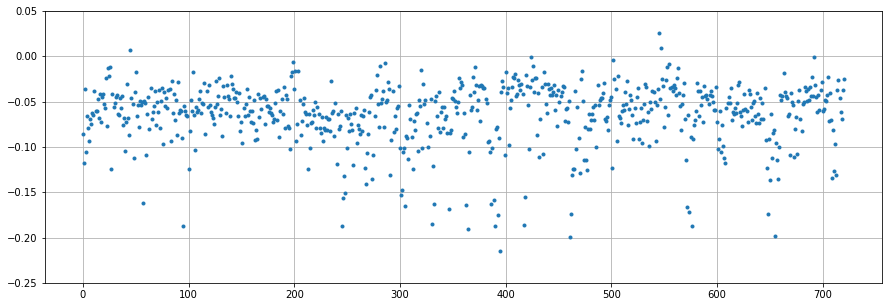

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(barf['color_term'], '.')
plt.ylim(-0.25, 0.05)
plt.grid()

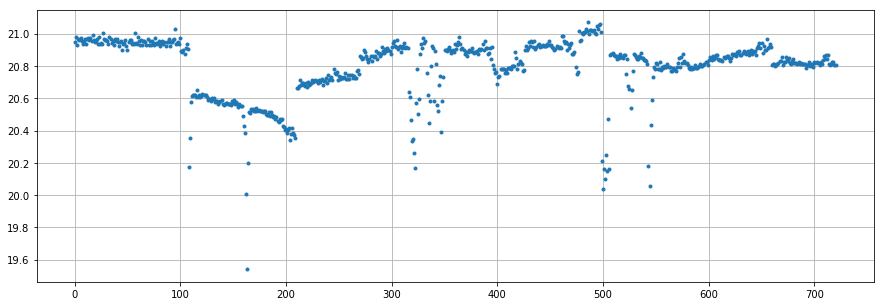

In [25]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(barf['zero_point'], '.')